# Shopee-Product-Matching
![Shopee](https://cdn.lynda.com/course/563030/563030-636270778700233910-16x9.jpg)


1. If you want to learn more about this amazing competition hosted by [Shopee](https://www.kaggle.com/c/shopee-product-matching), Please visit following [Shopee EDA Image AutoEncoder](https://www.kaggle.com/code/chiragtagadiya/shopee-basic-autoencoder).
2. This Notebook contains EDA and Image AutoEncoder solution.

In [1]:
%config Completer.use_jedi = False

# Import Packages

In [2]:
import sys
sys.path.append('../input/timmmaster')
import timm

In [3]:
import math
import os
import numpy as np
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import timm
import torch
from torch import nn 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F 
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
from datetime import date
from sklearn.metrics import f1_score, accuracy_score

# Configuration Options


In [4]:
TRAIN_DIR = '../input/shopee-product-matching/train_images'
TEST_DIR = '../input/shopee-product-matching/test_images'
TRAIN_CSV = '../input/crossvalidationfolds/folds.csv'
MODEL_PATH = './'


class CFG:
    seed = 123 
    img_size = 512
    classes = 11014
    fc_dim = 512
    epochs = 15
    batch_size = 32
    num_workers = 3
    model_name = 'tf_efficientnet_b4'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    scheduler_params = {
        "lr_start": 1e-3,
        "lr_max": 1e-5 * batch_size,
        "lr_min": 1e-6,
        "lr_ramp_ep": 5,
        "lr_sus_ep": 0,
        "lr_decay": 0.8,
    }
    model_path='../input/21-mar-lr-large/2022-03-20_softmax_512x512_tf_efficientnet_b4.pt'
    isTraining=False
    

# Solution Approach

* In this competition it is given that,if two or more images have **same label group** then they are **similar products.** 
* Basically we can use this information to transfer the business problem into **multi class classification** problem.
* From Image EDA, I found out that we have **11400** different classes, and dataset is **not balanced dataset**
* If you see below plot, we can clearly see that there are **hardly 1000 data points having more than 10 products per label.*
* In this notebook I used **Weighted Sampler technique used in pytorch for handling imbalanced classification problem**


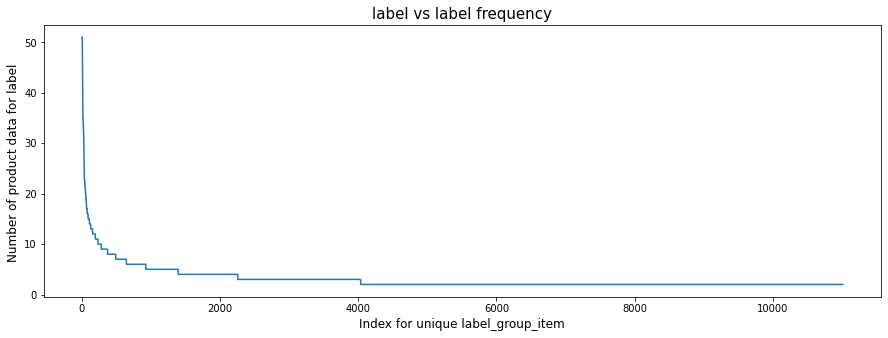

In [5]:
train_df=pd.read_csv('../input/shopee-product-matching/train.csv')
labelGroups = train_df.label_group.value_counts()
# print(labelGroups)
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(labelGroups)), labelGroups.values)
plt.xlabel("Index for unique label_group_item", size=12)
plt.ylabel("Number of product data for label ", size=12)
plt.title("label vs label frequency", size=15)
plt.show()

# Create Custom DataSet

In [6]:
class ShopeeDataset(Dataset):
    
    def __init__(self, df,root_dir, isTraining=False, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # get row at index idx
#         print("idx",idx)
        
        row = self.df.iloc[idx]
#         print(row)
        label = row.label_group
        image_path = os.path.join(self.root_dir, row.image)
        
        # read image convert to RGB and apply augmentation
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            aug = self.transform(image=image)
            image = aug['image']
        
        return image, torch.tensor(label).long()
            




# Create Data Augmentation For training and validation Data

In [7]:

def getAugmentation(IMG_SIZE, isTraining=False):
    
    if isTraining:
        return albumentations.Compose([
            albumentations.Resize(IMG_SIZE, IMG_SIZE, always_apply=True),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=120, p=0.75),
            albumentations.RandomBrightness(limit=(0.09, 0.6), p=0.5),
            albumentations.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225]
            ),
            ToTensorV2(p=1.0)
        ])
    else:
        return albumentations.Compose([
            albumentations.Resize(IMG_SIZE, IMG_SIZE, always_apply=True),
            albumentations.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225]
            ),
            ToTensorV2(p=1.0)
        ])

# Build Model

In [8]:
class ShopeeLabelGroupClassfier(nn.Module):
    
    def __init__(self,
                     model_name='tf_efficientnet_b0',
                     loss_fn='softmax',
                     classes = CFG.classes,
                     fc_dim = CFG.fc_dim,
                     pretrained=True,
                     use_fc=True,
                     isTraining=False
                ):
        
        
        super(ShopeeLabelGroupClassfier,self).__init__()
        
        # create bottlenack backbone network from pretrained model 
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.backbone.classifier.in_features
        # we will put FC layers over backbone to classfy images based on label groups
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.use_fc = use_fc
        self.loss_fn =loss_fn
        
        # build top fc layers
        if self.use_fc:
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(in_features,fc_dim )
            self.bn = nn.BatchNorm1d(fc_dim)
            in_features = fc_dim
        self.loss_fn = loss_fn
        
        if self.loss_fn=='softmax':
            self.final = nn.Linear(in_features, CFG.classes)
    
    def forward(self, image, label):
        features = self.get_features(image)
        
        if self.loss_fn=='softmax':
            logits = self.final(features)
            
        return logits
    
    def get_features(self,inp):
        batch_dim = inp.shape[0]
        inp = self.backbone(inp)
        inp = self.pooling(inp).view(batch_dim, -1)
        if self.use_fc:
            inp = self.dropout(inp)
            inp = self.fc(inp)
            inp = self.bn(inp)
        
        return inp
    
    
# shoppe_label_classfier = ShopeeLabelGroupClassfier()


# Training  Single Epoch


In [9]:
def training_one_epoch(epoch_num,model, dataloader,optimizer, scheduler, device, loss_criteria):
    avgloss = 0.0
    # put model in traning model
    model.train()
    tq = tqdm(enumerate(dataloader), total=len(dataloader))
    
    for idx, data in tq:
        batch_size = data[0].shape[0]
        images = data[0]
        targets = data[1]
        # zero out gradient
        optimizer.zero_grad()
        # put input and target to device
        images = images.to(device)
        targets = targets.to(device)
        # pass input to the model
        output = model(images,targets)
        # get loss
        loss = loss_criteria(output,targets)
        # backpropogation 
        loss.backward()
        # update learning rate step
        optimizer.step() 
        # avg loss
        avgloss += loss.item() 

        tq.set_postfix({'loss' : '%.6f' %float(avgloss/(idx+1)), 'LR' : optimizer.param_groups[0]['lr']})
        
    # lr scheduler step after each epoch
    scheduler.step()
    return avgloss / len(dataloader)
    
    
    
    
    
    

# Validating Single Epoch

In [10]:


def validation_one_epoch(model, dataloader, epoch, device, loss_criteria):
    avgloss = 0.0
    # put model in traning model
    model.eval()
    tq = tqdm(enumerate(dataloader), desc = "Training Epoch { }" + str(epoch+1))
    
    y_true=[]
    y_pred=[]
    with torch.no_grad():
        for idx, data in tq:
            batch_size = data[0].shape[0]
            images = data[0]
            targets = data[1]

            images = images.to(device)
            targets = targets.to(device)
            output = model(images,targets)
            predicted_label=torch.argmax(output,1)
            y_true.extend(targets.detach().cpu().numpy())
            y_pred.extend(predicted_label.detach().cpu().numpy())
            loss = loss_criteria(output,targets)

            avgloss += loss.item() 

            tq.set_postfix({'validation loss' : '%.6f' %float(avgloss/(idx+1))})
    f1_score_metric = f1_score(y_true, y_pred, average='micro')
    tq.set_postfix({'validation f1 score' : '%.6f' %float(f1_score_metric)})
    return avgloss / len(dataloader),f1_score_metric
        


## Helper Function for Handling class imbalanced data

In [11]:
import numpy as np 
def get_class_weights(data):
    weight_dict=dict()
    # Format of row : PostingId, Image, ImageHash, Title, LabelGroup
    # LabelGroup index is 4 and it is representating class information
    for row in data.values:
        weight_dict[row[4]]=0
    # Word dictionary keys will be label and value will be frequency of label in dataset
    for row in data.values:
        weight_dict[row[4]]+=1
    # for each data point get label count data
    class_sample_count= np.array([weight_dict[row[4]] for row in data.values])
    # each data point weight will be inverse of frequency
    weight = 1. / class_sample_count
    weight=torch.from_numpy(weight)
    return weight

# Training Loop

In [12]:
def run_training():
    data = pd.read_csv('../input/crossvalidationfolds/folds.csv')
    
    # label encoding
    labelencoder= LabelEncoder()
    data['label_group_original']=data['label_group']
    data['label_group'] = labelencoder.fit_transform(data['label_group'])
    #data['weights'] = data['label_group'].map(1/data['label_group'].value_counts())
    # create training_data and validation data initially not using k fold
    train_data = data[data['fold']!=0]
    # get weights for  classes
    samples_weight=get_class_weights(train_data)
    
    print("samples_weight", len(samples_weight))
    validation_data = data[data['fold']==0]
    
    # training augmentation
    train_aug = getAugmentation(CFG.img_size,isTraining=True )
    validation_aug = getAugmentation(CFG.img_size, isTraining=False)
    # create custom train and validation dataset
    
    trainset = ShopeeDataset(train_data, TRAIN_DIR, isTraining=True, transform = train_aug)
    validset = ShopeeDataset(validation_data, TRAIN_DIR, isTraining=False, transform = validation_aug)
    print(len(data), len(samples_weight))
    print(len(trainset))
    # create data sampler
                  
    sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, num_samples=len(samples_weight))   
    
    # create custom training and validation data loader num_workers=CFG.num_workers,
    train_dataloader = DataLoader(trainset, batch_size=CFG.batch_size,
                          drop_last=True,pin_memory=True, sampler=sampler)
    
    validation_dataloader = DataLoader(validset, batch_size=CFG.batch_size,
                         drop_last=True,pin_memory=True)
    
    
    # define loss function
    loss_criteria = nn.CrossEntropyLoss()
    loss_criteria.to(CFG.device)
    # define model
    
    model = ShopeeLabelGroupClassfier()
    model.to(CFG.device)
    
    # define optimzer
    optimizer = torch.optim.Adam(model.parameters(),lr= CFG.scheduler_params['lr_start'])
    
    # learning rate scheudler
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=7, T_mult=1, eta_min=1e-6, last_epoch=-1)
    
    history = {'train_loss':[],'validation_loss':[]}
    for epoch in range(CFG.epochs):
        
        # get current epoch training loss
        avg_train_loss = training_one_epoch(epoch_num = epoch,
                                           model = model,
                                           dataloader = train_dataloader,
                                           optimizer = optimizer,
                                           scheduler = scheduler,
                                           device = CFG.device, 
                                           loss_criteria = loss_criteria)
        
        # get current epoch validation loss
        avg_validation_loss = validation_one_epoch(model = model,
                                           dataloader = validation_dataloader,
                                           epoch = epoch,
                                           device = CFG.device,
                                           loss_criteria = loss_criteria)
        
        
        history['train_loss'].append(avg_train_loss)
        history['validation_loss'].append(avg_validation_loss)
        
        # save model
        torch.save(model.state_dict(), MODEL_PATH + str(date.today()) +'_softmax_512x512_{}.pt'.format(CFG.model_name))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
#             'scheduler': lr_scheduler.state_dict()
            },
            MODEL_PATH + str(date.today()) +'_softmax_512x512_{}_checkpoints.pt'.format(CFG.model_name)
        )
        
    return model, history

In [13]:
history=None
if CFG.isTraining:
    model, history = run_training()
    

# Plot Training and Validation Loss and Accuracy

In [14]:
if CFG.isTraining:
    epoch_lst = [ i+1 for i in range(15)]
    plt.plot(epoch_lst,history['train_loss'])

    plt.xlabel("Epoch number")
    plt.ylabel('Training Loss')
    plt.title('Training Loss SoftMax Loss Function')
    plt.show()

In [15]:
if CFG.isTraining:
    plt.plot(epoch_lst,history['validation_loss'])
    plt.xlabel("Epoch number")
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss SoftMax Loss Function')
    plt.show()

# Prediction 

In [16]:
def prediction(model):
    data = pd.read_csv('../input/crossvalidationfolds/folds.csv')

    # label encoding
    labelencoder= LabelEncoder()
    data['label_group'] = labelencoder.fit_transform(data['label_group'])
    # Prepare Validation data
    validation_data = data[data['fold']==0]
    validation_aug = getAugmentation(CFG.img_size,isTraining=False)
    validset = ShopeeDataset(validation_data, TRAIN_DIR, isTraining=False, transform = validation_aug)
    test_data_loader = torch.utils.data.DataLoader(validset,batch_size=CFG.batch_size)
    
    # put model in evalution mode
    
    model.eval()
    
    tq = tqdm(enumerate(test_data_loader))
    y_true=[]
    y_pred=[]
    with torch.no_grad():
        for idx, data in tq:
            images = data[0]
            targets = data[1]
            
            images = images.to(CFG.device)
            targets = targets.to(CFG.device)
            y_true.extend(targets.detach().cpu().numpy())
            output = model(images,targets)
            outputs=torch.argmax(output,1)
            y_pred.extend(outputs.detach().cpu().numpy())
        
    f1_score_metric = f1_score(y_true, y_pred, average='micro')
    return f1_score_metric
    

In [17]:
if not CFG.isTraining:
    model = ShopeeLabelGroupClassfier(pretrained=False).to(CFG.device)
    model.load_state_dict(torch.load(CFG.model_path))
    f1=prediction(model)
    print("F1 score {}".format(f1))

215it [03:15,  1.10it/s]

F1 score 0.6274452554744525
